In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import torch
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler

from dataloader.graph_ts_reader_30 import  MultiModalDataset, collate_fn
from dataloader.pyg_reader import global_node2idx_mapping
from model.final_model.mortality.final_model_loss_train_mortality import *
from model.final_model.mortality.final_model_mortality import PatientOutcomeModel
from model.retnet.autoencoder_v5_retnet import  TSAutoencoder
from model.final_model.mortality.plot import *


import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()



In [2]:
# ===  get global node2index for graph data === 
hdf = '/home/mei/nas/docker/thesis/data/hdf/'
train_diagnoses = pd.read_hdf(f'{hdf}train/diagnoses.h5',key='df')
global_node2idx = global_node2idx_mapping(train_diagnoses)

# === load Dataset  ===
train_data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"
test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

dataset_train = MultiModalDataset(train_data_dir,global_node2idx)
dataset_val = MultiModalDataset(val_data_dir,global_node2idx)
dataset_test = MultiModalDataset(test_data_dir,global_node2idx)

## load the inbalanced dataset sampler
labels_train = [int(dataset_train[i][5]) for i in range(len(dataset_train))]
labels_val = [int(dataset_val[i][5]) for i in range(len(dataset_val))]
labels_test = [int(dataset_test[i][5]) for i in range(len(dataset_test))]

train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_train)
val_sampler = ImbalancedDatasetSampler(dataset_val, labels=labels_val)
test_sampler = ImbalancedDatasetSampler(dataset_test, labels=labels_test)

# build the dataloader
train_loader = DataLoader( dataset_train,batch_size=128,sampler=train_sampler,collate_fn=collate_fn )
val_loader = DataLoader( dataset_val,batch_size=128,sampler=val_sampler,collate_fn=collate_fn)
test_loader = DataLoader( dataset_test,batch_size=128,sampler=test_sampler,collate_fn=collate_fn )

# train_loader = DataLoader( dataset_train,batch_size=32,shuffle=True,collate_fn=collate_fn )
# val_loader = DataLoader( dataset_val,batch_size=32,shuffle=False,collate_fn=collate_fn)
# test_loader = DataLoader( dataset_test,batch_size=32,shuffle=False,collate_fn=collate_fn )
train_loader_p = DataLoader(dataset_train, batch_size=128, shuffle=False, collate_fn=collate_fn)


Built 2150 patient-tree graphs
Built 461 patient-tree graphs
Built 461 patient-tree graphs


In [4]:
flat_input_dim = 104
hidden_dim = 128
graph_input_dim = 62

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === load pretrained model ===
pretrained =  TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

pretrained.load_state_dict(torch.load(
"/home/mei/nas/docker/thesis/data/model_results/retnet/resampled_30/stage3/best_joint.pth", map_location=device,weights_only=True ))
pretrained_encoder = pretrained.encoder
som = pretrained.som_layer

# === load final model ===
model = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [4]:
save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/mortality/resampled_30_datasampler"
# save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/combine/resampled_30_debug"
model, history = train_patient_outcome_model(model, 
            train_loader, val_loader, train_loader_p, device, optimizer,  epochs=20, save_dir=save_path, 
            gamma=100, beta=150, kappa=200,  eta=1, 
            patience = 5 )

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 524096


[Joint] Ep10: Calculating global target P...


[Joint] Early stopping at epoch 10 due to no improvement for 5 epochs.
[Joint] Loading best model weights.


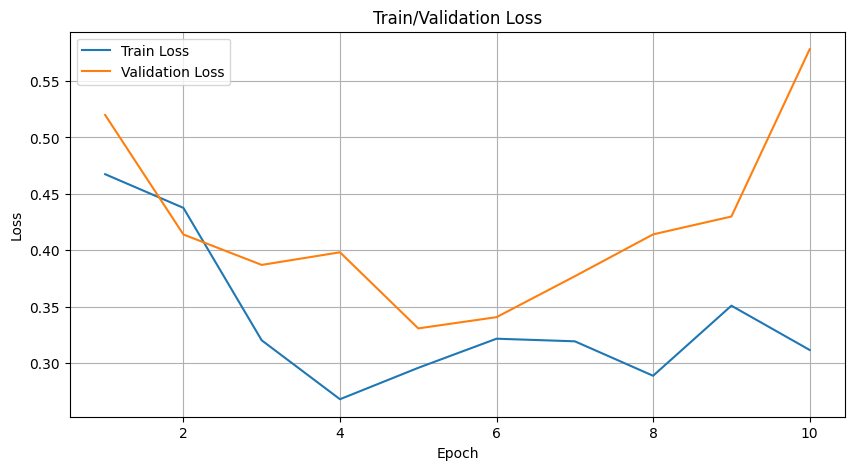

In [5]:
plot_training_history(history)

In [5]:
best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/mortality/resampled_30_datasampler/best_joint.pth'
model.load_state_dict(torch.load(best_model,weights_only=True))

<All keys matched successfully>

In [6]:
output= test_patient_outcome_model(model, test_loader, device)

Best threshold: 0.46587878 → F1: 0.8379446590316988
Total test samples: 461
Number of actual deaths: 127
Predictions range: min= 0.00061232  max= 0.96994454
Mean predicted death probability: 0.2420858
Test Mortality - AUROC: 0.9351, AUPRC: 0.8690, Precision: 0.8413, Recall: 0.8346,pecificity: 0.9401, F1: 0.8379


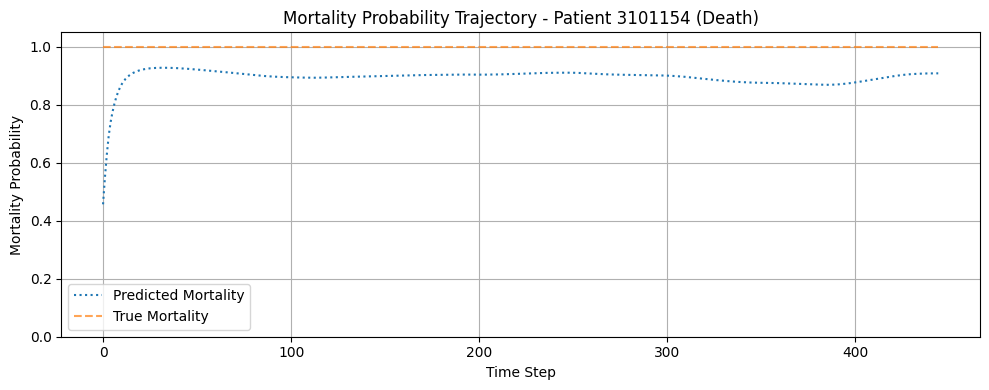

In [7]:
plot_patient_mortality_probability(model, test_loader, patient_index=317, device=device)

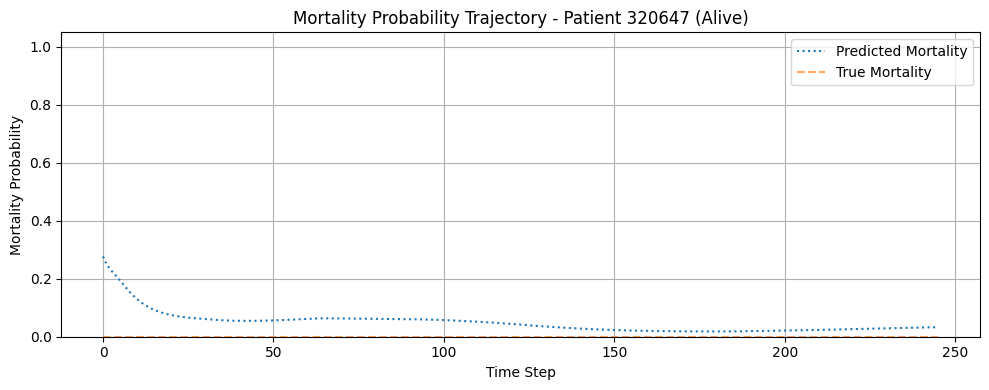

In [8]:
plot_patient_mortality_probability(model, test_loader, patient_index=398, device=device)

In [11]:
from matplotlib.colors import LogNorm
def plot_som_activation_heatmap(heatmap, som_dim, cmap="YlGnBu"):
    H, W = som_dim
    plt.figure(figsize=(W*0.6, H*0.6))
    sns.heatmap(
        heatmap,
        cmap=cmap,
        norm=LogNorm(vmin=max(heatmap.min(), 1e-3), vmax=heatmap.max()),
        annot=False,
        fmt="d",
        square=True,
        cbar_kws={"label": "Activation Count"}
    )
    plt.title("Overall SOM Activation")
    plt.xlabel("SOM Width")
    plt.ylabel("SOM Height")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

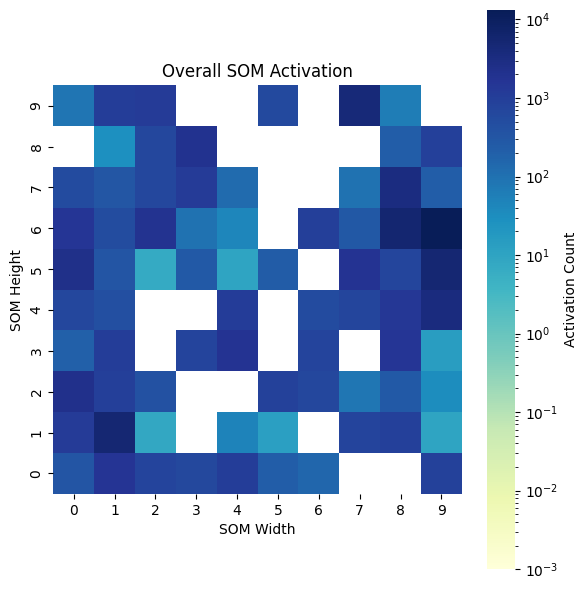

In [12]:
som_dim = (10,10)
activation_grid = compute_som_activation_heatmap(model, test_loader, device, som_dim)
plot_som_activation_heatmap(activation_grid, som_dim)

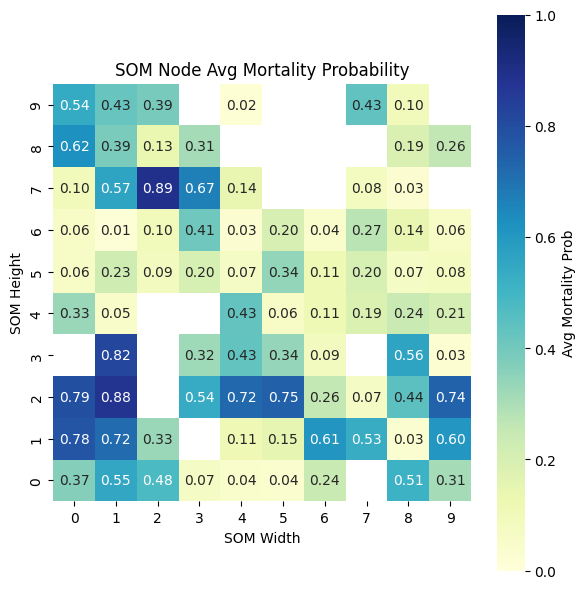

In [13]:
som_dim = (10,10)
mort_heatmap = compute_som_avg_mortality_prob(model, test_loader, device, som_dim)
plot_som_avg_mortality_prob(mort_heatmap, som_dim)

In [ ]:
# best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/risk/resampled_30_smooth/best_joint.pth'
# model2 = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device) 
# model2.load_state_dict(torch.load(best_model,weights_only=True))

<All keys matched successfully>

In [15]:
print_statistics_of_dataloaer(test_loader)

test_loader 中 cat=0 的样本索引： [327, 327, 327, 327, 194, 194, 194, 122, 122, 122, 122, 161, 161, 161, 161, 161, 161, 161, 161, 303, 303, 123, 123, 123, 123, 123, 127, 127, 127, 51, 51, 117, 117, 117, 117, 117, 117, 117, 241, 279, 109, 241, 109, 109, 109, 241, 109, 109, 241, 241, 279, 279, 109, 279, 61, 48, 61, 48, 61, 61, 61, 48, 48, 61, 61, 48, 61, 48, 302, 302, 53, 302, 302, 302, 53, 53, 53, 53, 302, 131, 114, 131, 18, 18, 131, 18, 114, 114, 131, 18, 77, 77, 77, 75, 75, 75, 75, 75, 75, 75, 75, 88, 88, 88, 88, 88, 88, 46, 46, 46, 46, 46, 43, 43, 43, 418, 43, 43, 418, 418, 418, 71, 71, 71, 71, 71, 71, 330, 330, 330, 330, 330, 330, 330, 330, 330]
cat=0 的患者 ID: [3118263, 3118263, 3118263, 3118263, 2441148, 2441148, 2441148, 1848702, 1848702, 1848702, 1848702, 2235716, 2235716, 2235716, 2235716, 2235716, 2235716, 2235716, 2235716, 3064491, 3064491, 1849239, 1849239, 1849239, 1849239, 1849239, 1854497, 1854497, 1854497, 1721495, 1721495, 1842081, 1842081, 1842081, 1842081, 1842081, 1842081, 18

In [14]:
# --- 1. 计算热力图 ---
som_dim = (10,10)
mort_heatmap = compute_som_avg_mortality_prob(model, test_loader, device, som_dim)

--- Searching for specified patient IDs: ['2441148'] ---


Searching for patients:   0%|          | 0/4 [00:00<?, ?it/s]

  -> Found 1 target(s) in batch. Forward pass...
    -> Trajectory for ID=2441148, category=0, mortality=0
--- All targets found. ---

Plotting trajectory snapshots at timesteps: [245]



/tmp/ipykernel_4132610/2152833681.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.7, 0.96])


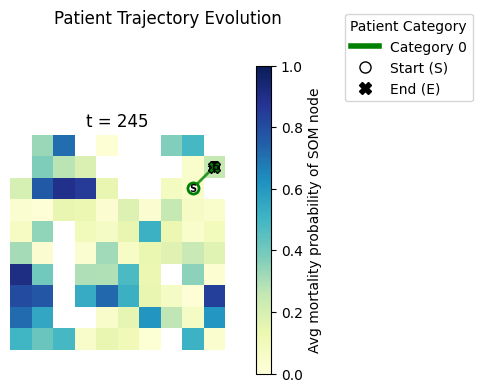

In [23]:
patient_ids = ['2441148'] 
# 2441148, 1848702, 1848702, 1848702, 1848702, 2235716,
targeted_trajectories =  compute_trajectories_by_id_or_category(
    model, 
    test_loader, 
    device, 
    som_dim=(10,10),
    target_patient_ids=patient_ids 
)
    

# --- 3. 绘图 ---
max_len = max(len(d["coords"]) for d in targeted_trajectories.values())

# 开始，1/4处，1/2处，3/4处，和结束前一个点
snapshot_timesteps = [
    max_len - 1 
]

snapshot_timesteps = sorted(list(set(snapshot_timesteps))) 

print(f"\nPlotting trajectory snapshots at timesteps: {snapshot_timesteps}")

plot_trajectory_snapshots_custom_color(
    heatmap=mort_heatmap, 
    trajectories=targeted_trajectories, 
    som_dim=(10, 10),
    snapshot_times=snapshot_timesteps
)

--- Searching for specified patient IDs: ['3120701'] ---


Searching for patients:   0%|          | 0/4 [00:00<?, ?it/s]

  -> Found 1 target(s) in batch. Forward pass...


Searching for patients:   0%|          | 0/4 [00:00<?, ?it/s]

    -> Trajectory for ID=3120701, category=3, mortality=1
--- All targets found. ---

Plotting trajectory snapshots at timesteps: [330]



/tmp/ipykernel_4132610/2152833681.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.7, 0.96])


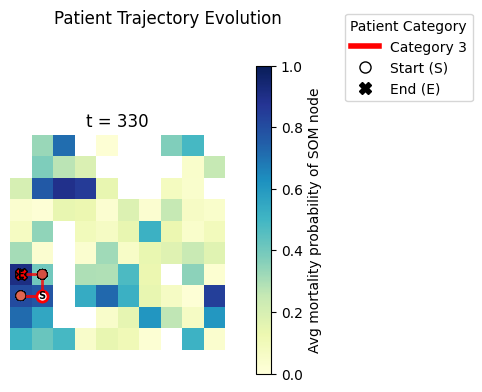

In [19]:
patient_ids = ['3120701'] 
targeted_trajectories =  compute_trajectories_by_id_or_category(
    model, 
    test_loader, 
    device, 
    som_dim=(10,10),
    target_patient_ids=patient_ids 
)
    

# --- 3. 绘图 ---
max_len = max(len(d["coords"]) for d in targeted_trajectories.values())

# 开始，1/4处，1/2处，3/4处，和结束前一个点
snapshot_timesteps = [
    max_len - 1 
]

snapshot_timesteps = sorted(list(set(snapshot_timesteps))) 

print(f"\nPlotting trajectory snapshots at timesteps: {snapshot_timesteps}")

plot_trajectory_snapshots_custom_color(
    heatmap=mort_heatmap, 
    trajectories=targeted_trajectories, 
    som_dim=(10, 10),
    snapshot_times=snapshot_timesteps
)